In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import poisson
from scipy.stats import skellam

In [7]:
# crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/integer_valued_ts/crime_480_data.xlsx')
crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/z-values-series/813_crimes.xlsx')
# "C:\Users\michelj8\Documents\GitHub\z-values-series\crime_230_data.xlsx"
# "C:\Users\michelj8\Documents\GitHub\expo_smooth_lasso\integer_valued_ts\crime_888_data.xlsx"

In [8]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190505845,2019-02-11,2019-02-05,730,5,Harbor,563,2,813,CHILD ANNOYING (17YRS & UNDER),...,IC,Invest Cont,813,NaN,NaN,NaN,13TH ST,CABRILLO,33.7324,-118.2946
1,190212708,2019-06-07,2019-06-03,320,2,Rampart,275,2,813,CHILD ANNOYING (17YRS & UNDER),...,IC,Invest Cont,813,NaN,NaN,NaN,1600 W 11TH ST,NaN,34.0506,-118.2769
2,191715992,2019-09-26,2019-09-25,1730,17,Devonshire,1777,2,813,CHILD ANNOYING (17YRS & UNDER),...,IC,Invest Cont,813,NaN,NaN,NaN,9800 WOODLEY AV,NaN,34.2422,-118.4897
3,191716137,2019-09-27,2019-09-26,1340,17,Devonshire,1737,2,813,CHILD ANNOYING (17YRS & UNDER),...,AO,Adult Other,813,NaN,NaN,NaN,16500 CHATSWORTH ST,NaN,34.2703,-118.4959
4,191914524,2019-08-06,2019-08-06,1200,19,Mission,1935,2,813,CHILD ANNOYING (17YRS & UNDER),...,IC,Invest Cont,813,NaN,NaN,NaN,15100 S BRAND BL,NaN,34.2752,-118.4603


In [9]:
crime_data['Crm Cd Desc'].unique()

array(['CHILD ANNOYING (17YRS & UNDER)'], dtype=object)

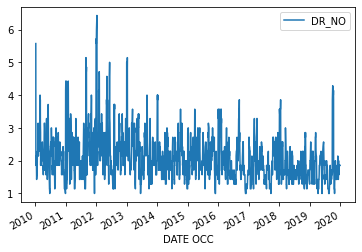

In [10]:
crime_data.groupby(['DATE OCC']).count()[['DR_NO']].rolling(window = 7).mean().plot()

In [11]:
ts_df = crime_data.groupby(['DATE OCC']).count()[['DR_NO']].reset_index()
ts_df['year-month'] = ts_df['DATE OCC'].apply(lambda s: str(s)[0:7])

ts_df = ts_df.groupby('year-month').sum()
ts_df.columns = ['Y']

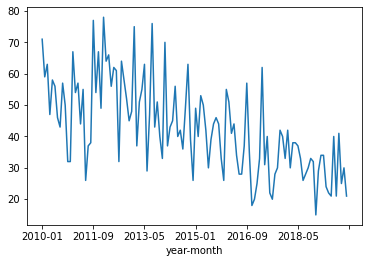

In [12]:
ts_df['Y'].plot()

In [13]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_df, (1,0)).fit()
model.params

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      42.912993
ar.L1.Y     0.424788
dtype: float64

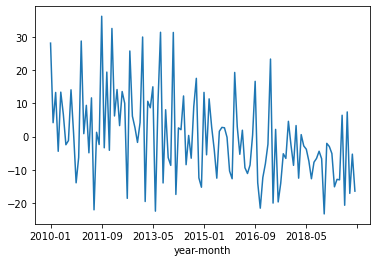

In [14]:
model.resid.plot()

# Add in transformations and plots

In [15]:
ts_df['delta'] = ts_df['Y'].diff(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])

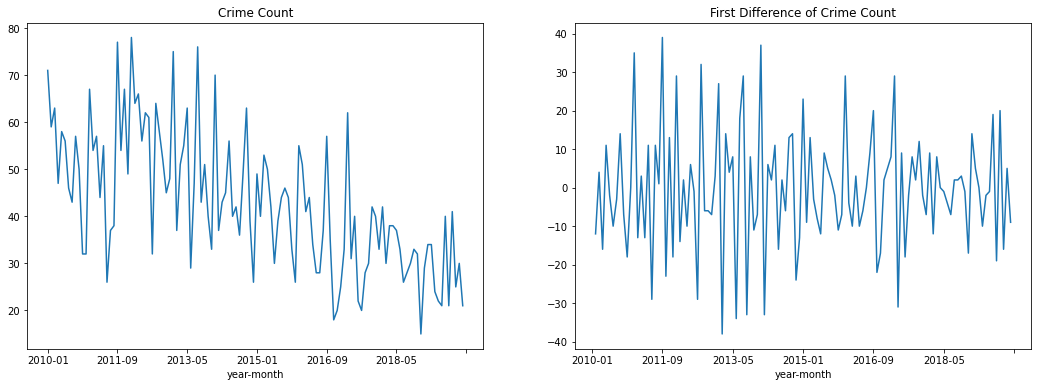

In [16]:
fig, ax  = plt.subplots(1,2, figsize = (18,6))

ts_df['Y'].plot(ax = ax[0], title = 'Crime Count')
ts_df['delta'].plot(ax = ax[1], title = 'First Difference of Crime Count')

In [17]:
ts_df['delta'].describe()

count    119.000000
mean      -0.420168
std       15.504234
min      -38.000000
25%      -10.000000
50%        0.000000
75%        8.500000
max       39.000000
Name: delta, dtype: float64

In [18]:
rolling_summary_df = pd.DataFrame(columns = ['mean','var','abs','sign'])

rolling_summary_df['mean'] = ts_df['delta'].rolling(window = 12).mean()
rolling_summary_df['var'] = np.square(ts_df['delta'].rolling(window = 12).std())
rolling_summary_df['abs'] = np.abs(ts_df['delta']).rolling(window = 12).mean()
rolling_summary_df['sign'] = np.sign(ts_df['delta']).rolling(window = 12).mean()

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


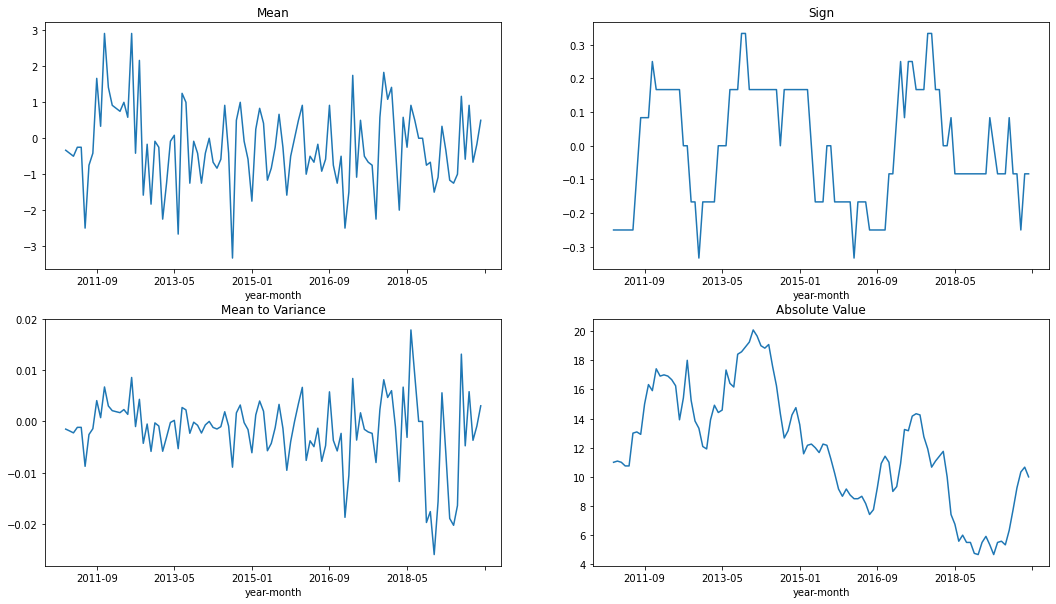

In [19]:
fig, ax = plt.subplots(2,2, figsize = (18,10))

rolling_summary_df['mean'].plot(ax = ax[0][0], title = 'Mean')
# rolling_summary_df['var'].plot(ax = ax[1][0], title = 'Variance')
(rolling_summary_df['mean']/rolling_summary_df['var']).plot(ax = ax[1][0], title = 'Mean to Variance')
rolling_summary_df['sign'].plot(ax = ax[0][1], title = 'Sign')
rolling_summary_df['abs'].plot(ax = ax[1][1], title = 'Absolute Value')

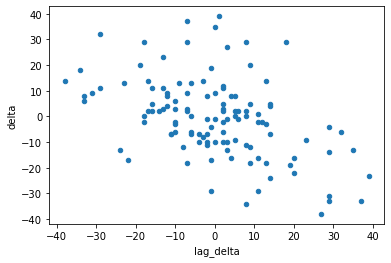

In [20]:
ts_df['lag_delta'] = ts_df['delta'].shift(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])
ts_df.plot.scatter(x='lag_delta',y='delta')

In [21]:
from statsmodels.tsa.stattools import acf, pacf
acf(ts_df['delta'].dropna())

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        , -0.46206118,  0.0123984 , -0.15536936,  0.12909391,
       -0.01803651, -0.01792926,  0.01039805,  0.12831741, -0.10390666,
       -0.06112905, -0.11740537,  0.33280577, -0.20396758,  0.09946925,
       -0.13144832,  0.10015271, -0.05538522,  0.0150235 , -0.04684558,
        0.16277398, -0.13267869, -0.06907917, -0.00782661,  0.26845964,
       -0.19765553,  0.04799317, -0.12017247,  0.12218481, -0.05998051,
        0.05533237, -0.03400519,  0.10911359, -0.14410807,  0.06282236,
       -0.1558556 ,  0.20516612, -0.04993886,  0.08484292, -0.19058863,
        0.07671478])

const         -0.366381
ar.L1.delta   -0.461628
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


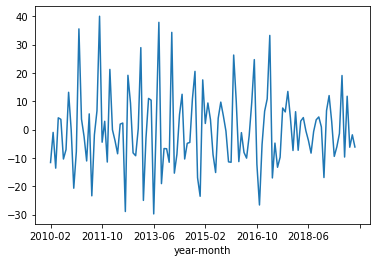

In [22]:
model = ARMA(ts_df['delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

const              11.875853
ar.L1.abs_delta     0.219364
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


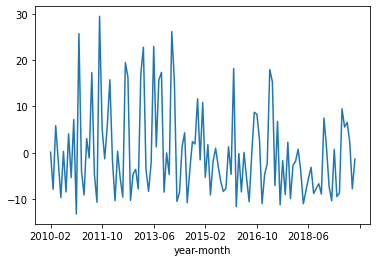

In [23]:
model = ARMA(ts_df['abs_delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

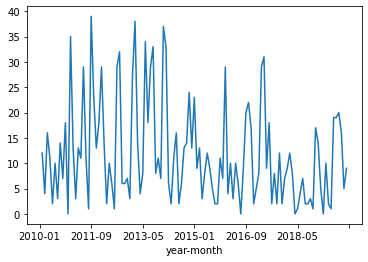

In [24]:
ts_df['abs_delta'].plot()

In [25]:
ts_df['delta_lag'] = ts_df['delta'].shift(1)

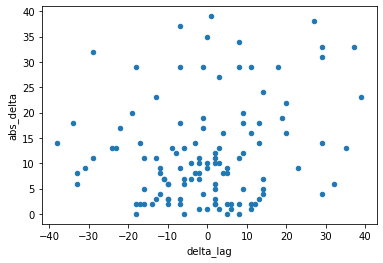

In [26]:
ts_df.plot.scatter(x='delta_lag' ,y='abs_delta')

# Estimation

## Time trend AR-Poisson

In [27]:
def tt_ar_pois(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    ll_value = 0
    mean_est = omega
    inf_status = 0
    
    for r in range(1,sample_size):
        new_y = ts[r]
#         ll_value = -1*np.log( poisson.pmf(new_y ,mean_est) )
        obs_ll_value = poisson.pmf(new_y,mean_est)
        ll_value = ll_value + obs_ll_value
        mean_est = gamma*r + omega + alpha*new_y + beta*mean_est
        
        if obs_ll_value < -100:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [28]:
def tt_ar_pois_filter(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    mean_est = [omega]
    
    for r in range(1, sample_size):
        new_y = ts[r]
        new_mean_est = gamma*r + omega + alpha*new_y + beta*mean_est[-1]
        mean_est.append(new_mean_est)
        
    filter_df = pd.DataFrame({'Y':ts,'mean_est':mean_est})
    filter_df['mean_est'] = filter_df['mean_est'].shift(1)
    filter_df = filter_df.dropna()
    return filter_df

In [29]:
Y = ts_df['Y'].dropna()

initial_guess = [1,1,.1,.2]
guess = initial_guess.copy()

for iteration in range(0,30):
    res_g = minimize_scalar( lambda g_hat : tt_ar_pois(g_hat, guess[1], guess[2], guess[3],Y ), bounds = (.01,3), method = 'bounded')
    guess[0] = res_g.x

    res_o = minimize_scalar( lambda o_hat : tt_ar_pois(guess[0], o_hat, guess[2], guess[3],Y ), bounds = (.01,3),  method = 'bounded')
    guess[1] = res_o.x

    res_a = minimize_scalar( lambda a_hat : tt_ar_pois(guess[0], guess[1], a_hat, guess[2],Y ), bounds = (0,1), method = 'bounded')
    guess[2] = res_a.x

    res_b = minimize_scalar( lambda b_hat : tt_ar_pois(guess[0], guess[1], guess[2], b_hat,Y ), bounds = (0, 1) , method = 'bounded')
    guess[3] = res_b.x

guess

[0.01000347428866272,
 2.7614530311901677,
 0.3598348635975997,
 0.5426995461622511]

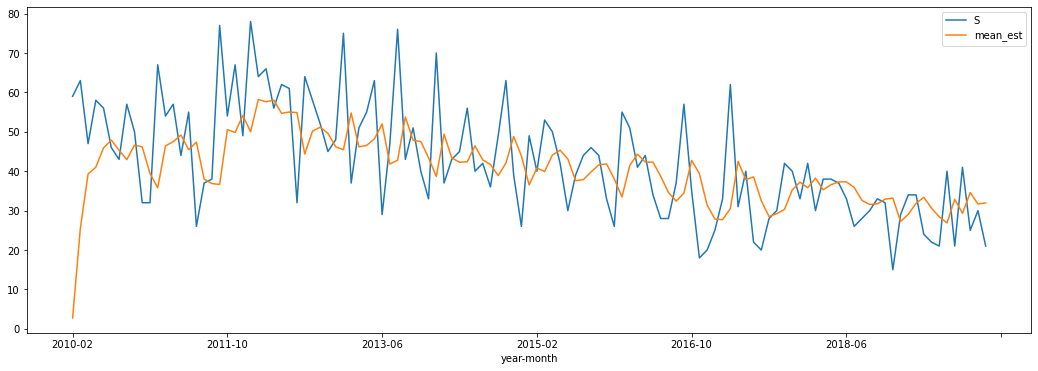

In [30]:
gamma,omega,alpha,beta  = guess
mle_df = tt_ar_pois_filter(gamma,omega,alpha,beta,Y)

fig, ax = plt.subplots(figsize = (18,6))
mle_df.plot(ax =ax)
ax.legend(['S','mean_est'])

0.2689075630252101

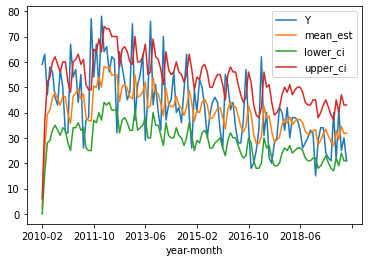

In [31]:
ci_alpha = .95

for index in mle_df.index:
    ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('Y < lower_ci | Y > upper_ci'))/len(mle_df)

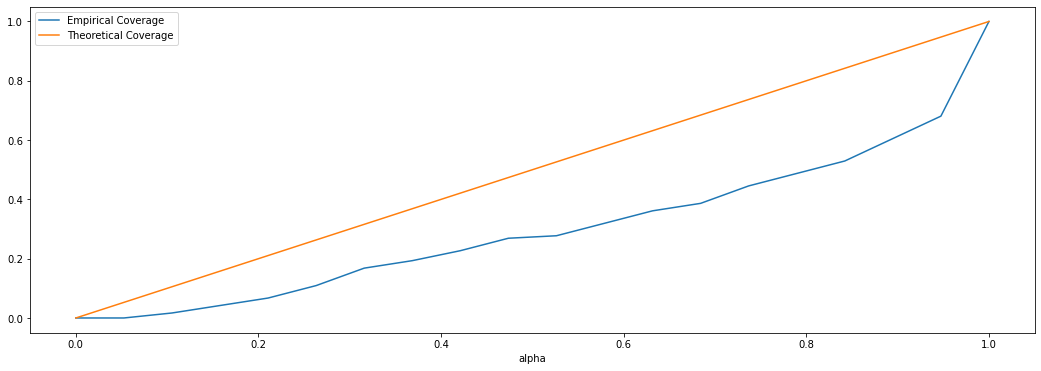

In [32]:
ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'actual_coverage'] = len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])

## Skellam Estimation

In [28]:
def censor(val,lower_bound, upper_bound):
    return min( max(val,lower_bound), upper_bound)

In [29]:
def skellam_ar(o,a,b,r,ts):
    sample_size = len(ts)
    r_factor = .5*(3*r-1)/(r+1)
    
    ll_value = 0
    mean_est = ts[0]
    
    inf_status = 0
    
    for r in range(1,sample_size):
        state_var = abs(mean_est) * (r_factor + .5*np.sign(mean_est)*np.array([1,-1]))
        new_y = censor(ts[r], -20,20)
        
        obs_ll_value = np.log( skellam(state_var[0],state_var[1]).pmf(new_y) )
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
        if obs_ll_value < -200:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [30]:
def skellam_ar_ols(o,a,b,r,ts):
    sample_size = len(ts)
    
    ll_value = 0
    mean_est = ts[0]
        
    for r in range(1,sample_size):
        new_y = censor(ts[r],-20,20)
        
        obs_ll_value = np.square(ts[r]-mean_est)
        
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
            
    return ll_value

In [31]:
def skellam_filter(c,a,b,r,ts):
    sample_size = len(ts)

    mu_est = [ts[0]]
    for time in range(1,sample_size):
        new_mu_est = c+a*ts[time] + b*mu_est[-1]
        mu_est.append(new_mu_est)
    
    filter_df = pd.DataFrame({'obs':ts, 'mu_est':mu_est})
    filter_df['mu_est'] = filter_df['mu_est'].shift(1)
    filter_df = filter_df.dropna()
    
    r_factor = .5*(3*r-1)/(r+1)
    filter_df['state1'] = filter_df['mu_est'].apply(lambda s: abs(s)*(r_factor + .5*np.sign(s)) )
    filter_df['state2'] =filter_df['mu_est'].apply(lambda s: abs(s)*(r_factor - .5*np.sign(s)) )
    
    return filter_df

In [46]:
delta_series = ts_df['delta'].dropna()

initial_guess = [1.55,.5,.2, 5.0]
guess = initial_guess.copy()

for iteration in range(0,10):
    res_o = minimize_scalar( lambda o_hat : skellam_ar(o_hat, guess[1], guess[2], guess[3], delta_series ), bounds = (-2,2),  method = 'bounded')
    guess[0] = res_o.x

    res_a = minimize_scalar( lambda a_hat : skellam_ar(guess[0],a_hat, guess[2], guess[3],  delta_series ), bounds = (0,1-guess[2]), method = 'bounded')
    guess[1] = res_a.x

    res_b = minimize_scalar( lambda b_hat : skellam_ar(guess[0], guess[1], b_hat, guess[3], delta_series ), bounds = (0, 1-guess[1]) , method = 'bounded')
    guess[2] = res_b.x
    
#     res_r = minimize_scalar( lambda r_hat : skellam_ar(guess[0], guess[1], guess[2], r_hat , Y ), bounds = (1.5,5), method = 'bounded')
#     guess[3] = res_r.x


guess

[-0.47747497869262434, 0.9787976572079731, 0.021196405424026548, 5.0]

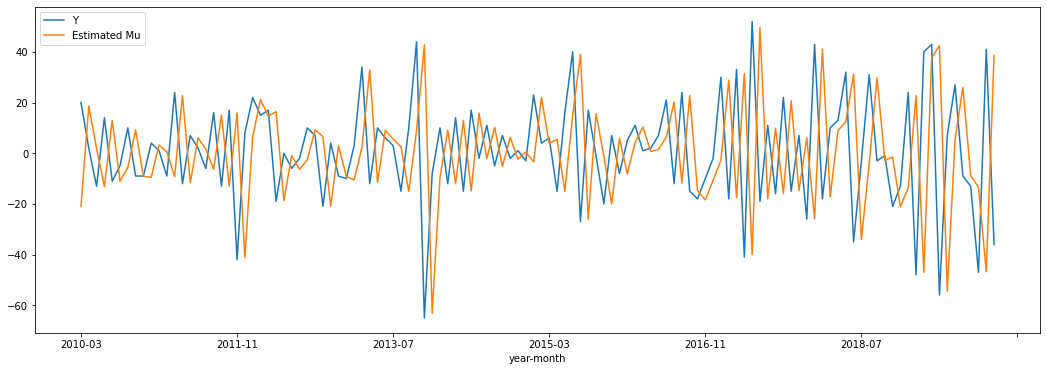

In [56]:
# c,a,b,r = initial_guess
c,a,b,r = guess
guess[3] = 100.0
# c,a,b,r = [1.5,.5,.2, 2.0]

fig, ax = plt.subplots(figsize = (18,6))

mle_df = skellam_filter(c,a,b,r,delta_series) 
mle_df[['obs','mu_est']].plot(ax = ax)
ax.legend(['Y','Estimated Mu'])

0.788135593220339

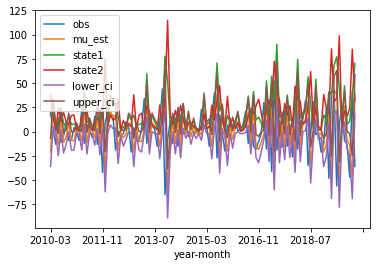

In [57]:
ci_alpha = .95

for index in mle_df.index:
    ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('obs < lower_ci | obs > upper_ci'))/len(mle_df)

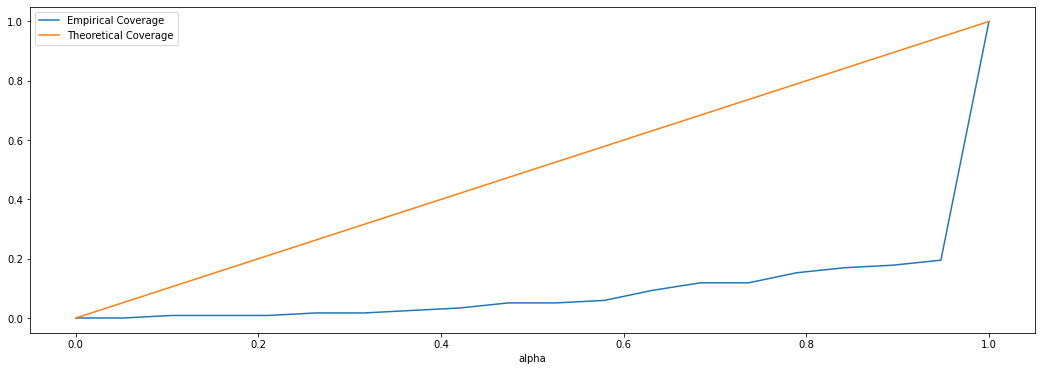

In [58]:
ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'actual_coverage'] = len(mle_df.query('obs > lower_ci & obs < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])